In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
df = pd.read_pickle("../data/processed/df_data.pkl")
print(df.head())

  record_id                                             signal   age     sex  \
0   JS00001  [-0.254, -0.254, -0.254, -0.254, -0.264, -0.27...  85.0    Male   
1   JS00002  [-0.01, -0.024, -0.02, 0.01, 0.01, -0.029, -0....  59.0  Female   
2   JS00004  [0.195, 0.195, 0.195, 0.195, 0.176, 0.166, 0.1...  66.0    Male   
3   JS00005  [0.005, 0.005, -0.015, -0.005, -0.005, -0.049,...  73.0  Female   
4   JS00006  [-0.029, -0.029, -0.029, -0.029, -0.034, -0.03...  46.0  Female   

        diagnosticos  
0  [AFIB, RBBB, TWC]  
1          [SB, TWC]  
2               [SB]  
3   [AF, STDD, STTC]  
4               [SB]  


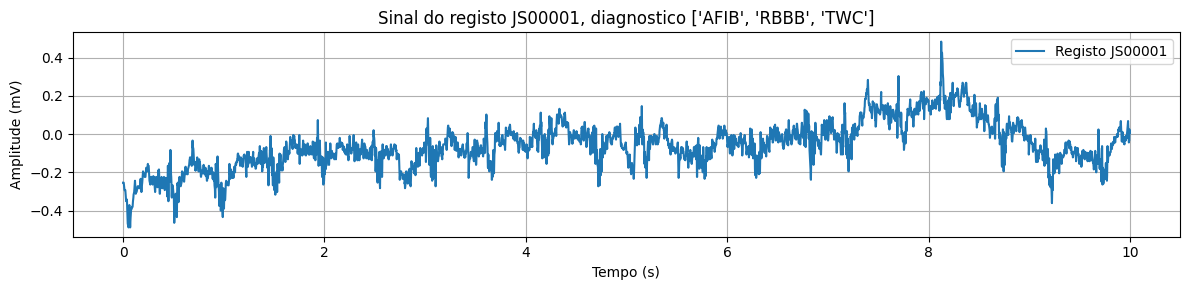

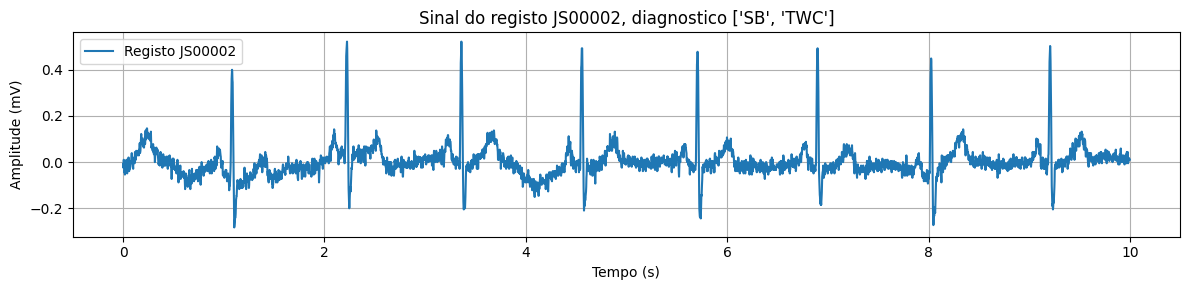

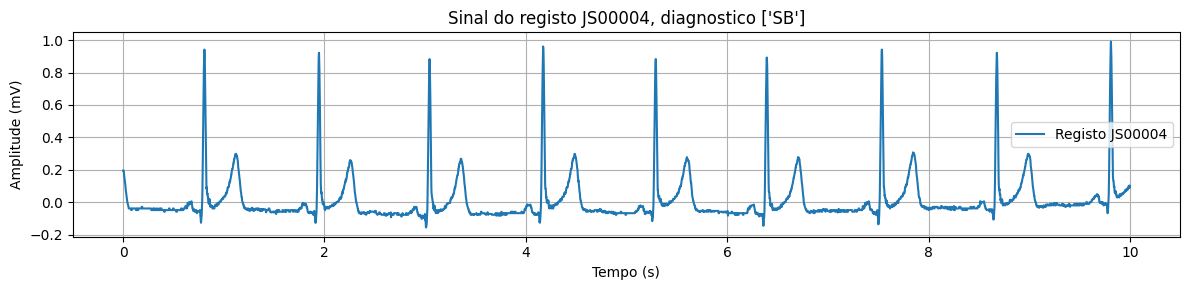

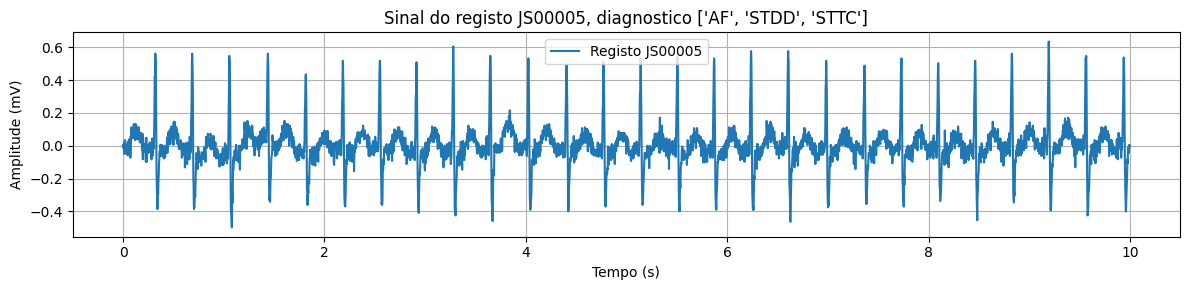

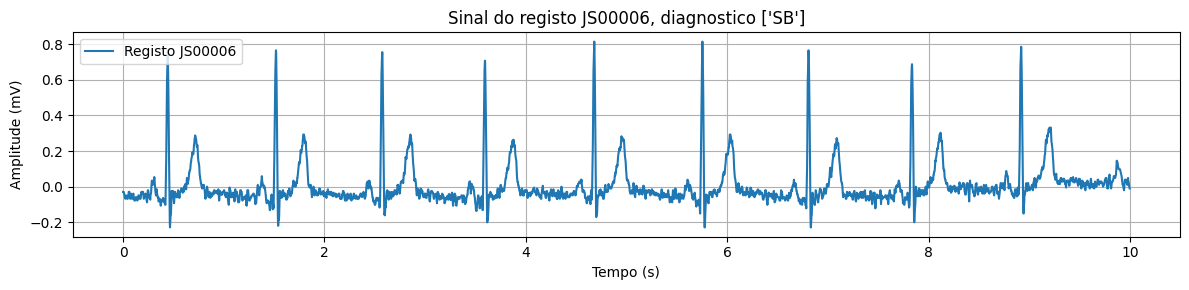

In [3]:
fs = 500  # sampling rate

for i in range(5):
    sinal = df.iloc[i]["signal"]
    tempo = [j / fs for j in range(len(sinal))]  # eixo x em segundos

    plt.figure(figsize=(12, 3))
    plt.plot(tempo, sinal, label=f"Registo {df.iloc[i]['record_id']}")
    plt.title(f"Sinal do registo {df.iloc[i]['record_id']}, diagnostico {df.iloc[i]['diagnosticos']}")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

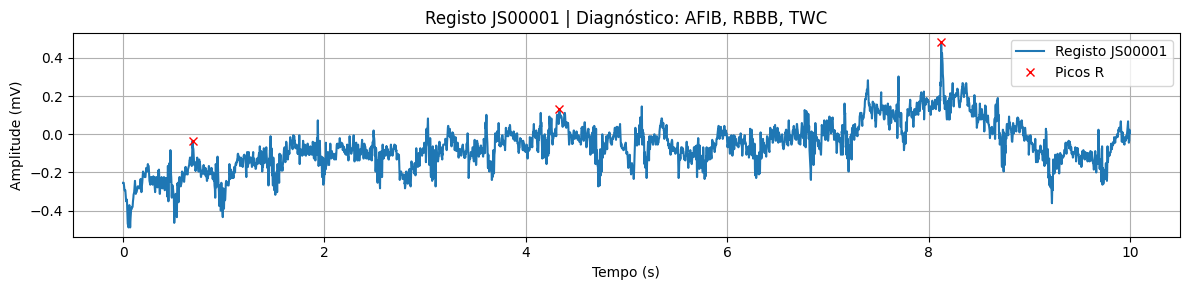

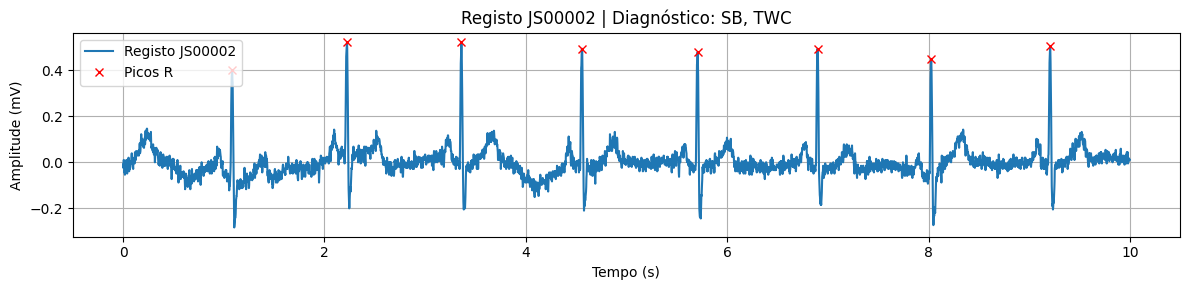

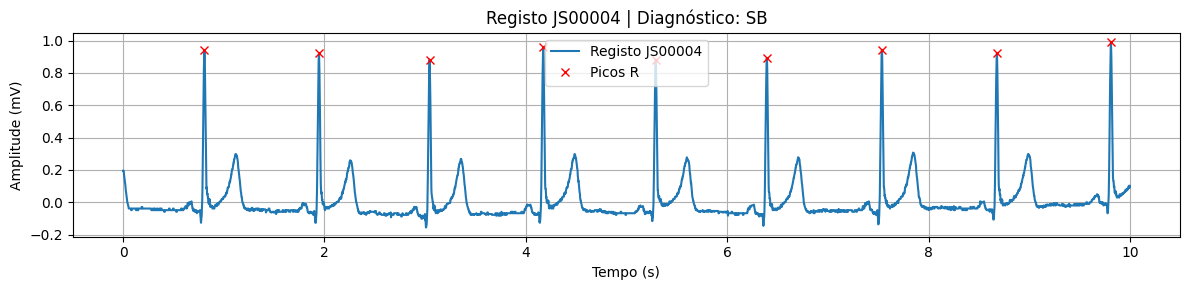

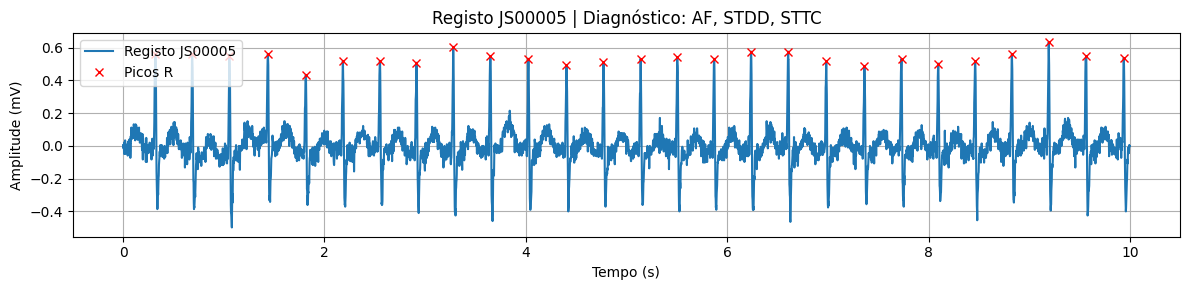

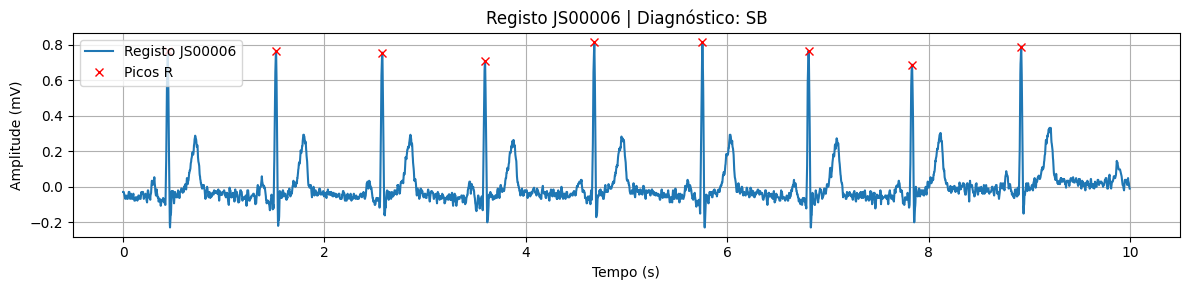

In [4]:
for i in range(5):
    sinal = df.iloc[i]["signal"]
    tempo = [j / fs for j in range(len(sinal))]
    diagnostico = ", ".join(df.iloc[i]["diagnosticos"])  # transforma lista numa string

    # Detetar picos R
    picos, _ = find_peaks(sinal, distance=fs * 0.3, prominence=0.4)

    # Plot
    plt.figure(figsize=(12, 3))
    plt.plot(tempo, sinal, label=f"Registo {df.iloc[i]['record_id']}")
    plt.plot(np.array(tempo)[picos], np.array(sinal)[picos], "rx", label="Picos R")
    plt.title(f"Registo {df.iloc[i]['record_id']} | Diagnóstico: {diagnostico}")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
fs = 500
r_peaks_list = []

for i in range(len(df)):
    sinal = df.iloc[i]["signal"]
    picos, _ = find_peaks(sinal, distance=fs * 0.3, prominence=0.4)
    r_peaks_list.append(picos.tolist())

df["r_peaks"] = r_peaks_list

# Média de picos por registo
print(f"Média de picos R por registo: {df['r_peaks'].apply(len).mean():.2f} picos")
# Desvio padrão de picos por registo
print(f"Desvio padrão de picos R por registo: {df['r_peaks'].apply(len).std():.2f} picos")
# Número de registos com menos de 5 picos
print(f"Número de registos com menos de 5 picos: {len(df[df['r_peaks'].apply(len) < 5])}")
# Número de registos com mais de 23 picos
print(f"Número de registos com mais de 23 picos: {len(df[df['r_peaks'].apply(len) > 23])}")

Média de picos R por registo: 12.12 picos
Desvio padrão de picos R por registo: 5.51 picos
Número de registos com menos de 5 picos: 3195
Número de registos com mais de 23 picos: 1532


In [4]:
fs = 500  # sampling rate
rr_metrics = []

for r_peaks in df["r_peaks"]:
    if len(r_peaks) < 2:
        rr_metrics.append({"rr_std": None, "rr_cv": None, "pnn50": None})
        continue

    rr = np.diff(r_peaks) / fs
    rr_std = np.std(rr)
    rr_mean = np.mean(rr)
    rr_cv = rr_std / rr_mean if rr_mean > 0 else None
    pnn50 = np.sum(np.abs(np.diff(rr)) > 0.05) / len(rr)  # 0.05s = 50ms

    rr_metrics.append({
        "rr_std": rr_std,  # Desvio padrão
        "rr_cv": rr_cv,  # Coeficiente de variação
        "pnn50": pnn50
        # Percentagem de intervalos RR cardíacos adjacentes com diferença de duração superior a 50 milissegundos
    })


In [5]:
# Adicionar ao df
df_rr = pd.DataFrame(rr_metrics)
df = pd.concat([df, df_rr], axis=1)

In [6]:
# Coluna sexo transformada em binário Female = 0 Male = 1
df["male"] = df["sex"].apply(lambda x: 1 if x == "Male" else 0)
df = df.drop(columns=["sex"])

In [7]:
print(df.head())

  record_id                                             signal   age  \
0   JS00001  [-0.254, -0.254, -0.254, -0.254, -0.264, -0.27...  85.0   
1   JS00002  [-0.01, -0.024, -0.02, 0.01, 0.01, -0.029, -0....  59.0   
2   JS00004  [0.195, 0.195, 0.195, 0.195, 0.176, 0.166, 0.1...  66.0   
3   JS00005  [0.005, 0.005, -0.015, -0.005, -0.005, -0.049,...  73.0   
4   JS00006  [-0.029, -0.029, -0.029, -0.029, -0.034, -0.03...  46.0   

        diagnosticos                                            r_peaks  \
0  [AFIB, RBBB, TWC]                                  [345, 2167, 4063]   
1          [SB, TWC]    [541, 1112, 1680, 2279, 2853, 3449, 4013, 4604]   
2               [SB]  [404, 973, 1522, 2086, 2645, 3197, 3768, 4339,...   
3   [AF, STDD, STTC]  [160, 343, 527, 719, 907, 1091, 1275, 1457, 16...   
4               [SB]  [221, 759, 1287, 1797, 2340, 2877, 3404, 3918,...   

     rr_std     rr_cv     pnn50  male  
0  0.074000  0.019903  0.500000     1  
1  0.026766  0.023057  0.571429     

In [8]:
# Filtrar casos com menos de 4 picos R
df_filtrado = df[df["r_peaks"].apply(lambda x: len(x) >= 4)].copy()

# Filtrar casos com mais de 23 picos R
df_filtrado = df_filtrado[df_filtrado["r_peaks"].apply(lambda x: len(x) <= 23)].copy()

print(f"Número de amostras pré filtros: {len(df)}")
print(f"Número de amostras após filtros: {len(df_filtrado)}")

Número de amostras pré filtros: 45150
Número de amostras após filtros: 40836


In [9]:
df.to_pickle("data/processed/df_peaks_fp.pkl")
df_filtrado.to_pickle("data/processed/df_filter.pkl")

In [12]:
# Antes da filtragem
num_afib_antes = df["diagnosticos"].apply(lambda x: "AFIB" in x).sum()
num_nao_afib_antes = len(df) - num_afib_antes

# Depois da filtragem
df_filtrado = df[df["r_peaks"].apply(lambda x: 4 <= len(x) <= 23)].copy()
num_afib_depois = df_filtrado["diagnosticos"].apply(lambda x: "AFIB" in x).sum()
num_nao_afib_depois = len(df_filtrado) - num_afib_depois

print(f"Antes da filtragem: {num_afib_antes} com AFIB, {num_nao_afib_antes} sem AFIB")
print(f"Depois da filtragem: {num_afib_depois} com AFIB, {num_nao_afib_depois} sem AFIB")

# percentagem com e sem afib antes e depois da filtragem
percentagem_afib_antes = num_afib_antes / len(df) * 100
percentagem_nao_afib_antes = num_nao_afib_antes / len(df) * 100
percentagem_afib_depois = num_afib_depois / len(df_filtrado) * 100
percentagem_nao_afib_depois = num_nao_afib_depois / len(df_filtrado) * 100
print(f"Antes da filtragem: {percentagem_afib_antes:.2f}% com AFIB, {percentagem_nao_afib_antes:.2f}% sem AFIB")
print(f"Depois da filtragem: {percentagem_afib_depois:.2f}% com AFIB, {percentagem_nao_afib_depois:.2f}% sem AFIB")

Antes da filtragem: 1780 com AFIB, 43370 sem AFIB
Depois da filtragem: 1567 com AFIB, 39269 sem AFIB
Antes da filtragem: 3.94% com AFIB, 96.06% sem AFIB
Depois da filtragem: 3.84% com AFIB, 96.16% sem AFIB
